In [1]:
import nb_utils

Moving cwd to /store/CIA/js2164/repos/diffusion/score_sde_pytorch


In [2]:
import torch
import pandas as pd
import numpy as np
from lightning_modules.VAE import VAE
from dim_reduction import inspect_VAE
from matplotlib import pyplot as plt

In [3]:
# get config
from configs.VAE.celebA import get_config
config = get_config()

User: js2164

Machine: holly-a.damtp.cam.ac.uk



In [4]:
vae = VAE(config).load_from_checkpoint('logs/VAE/celeba/kl_0.01/latent_dim_512_v1/checkpoints/last.ckpt', config=config)

Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/VAE/celeba/kl_0.01/latent_dim_512_v1/checkpoints/last.ckpt`


In [5]:
import torchvision
path_jan = 'images_for_manipulation/jan3.jpg'
#jan=torchvision.io.read_image(path_jan)[:,:150,:]
jan=torchvision.io.read_image(path_jan)
min_dim = min(jan.shape[1], jan.shape[2])
offset = 0
jan = jan[:, offset:(min_dim+offset), :min_dim]
georgios = torchvision.io.read_image('images_for_manipulation/georgios.jpg')[:,25:225,50:250]
resize = torchvision.transforms.Resize((64,64))
jan=resize(jan)
# normalize to 0, 1
jan = jan/255
georgios=resize(georgios)
georgios = georgios/255

In [6]:
from vae_run_lib import get_datamodule
data_module = get_datamodule(config)
data_module.setup()
val_dataloader = data_module.val_dataloader()
x = next(iter(val_dataloader))
print(x.shape)
# min max
print(x.min(), x.max())
print(x.mean(), x.std())

torch.Size([128, 3, 64, 64])
tensor(0.) tensor(1.)
tensor(0.4287) tensor(0.2732)


In [7]:
# reapeat jan 128 times
B=128
jan_batch = torch.stack([jan]*128)
latent_mean = False
reconstructed_jan = vae.reconstruct(jan_batch, use_latent_mean=latent_mean)
#reconstructed_jan, _ = vae.decode(mean_latent_jan)
# georgios
georgios_batch = torch.stack([georgios]*128)
reconstructed_georgios = vae.reconstruct(georgios_batch, use_latent_mean=latent_mean)
# x
x_batch = torch.stack([x[0]]*128)
reconstructed_x = vae.reconstruct(x_batch, use_latent_mean=latent_mean)

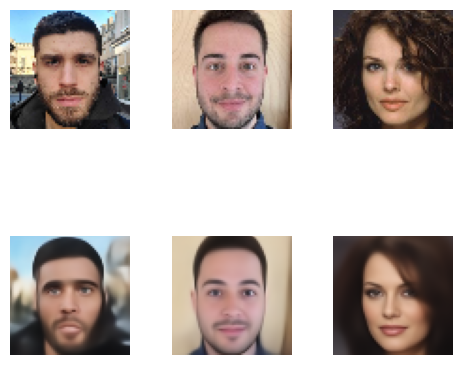

In [8]:
# show jan and georgios on one figure
fig, ax = plt.subplots(2,3, figsize=(5,5))
ax[0,0].imshow(jan.permute(1,2,0))
ax[0,1].imshow(georgios.permute(1,2,0))
ax[0,2].imshow(x[0].permute(1,2,0))
ax[1,0].imshow(reconstructed_jan[0].detach().permute(1,2,0))
ax[1,1].imshow(reconstructed_georgios[0].detach().permute(1,2,0))
ax[1,2].imshow(reconstructed_x[0].detach().permute(1,2,0))
# tight layout
plt.tight_layout()
# no axis
for a in ax.flatten():
    a.axis('off')   
plt.show()

# Ours

In [14]:
import pickle
from utils import fix_rds_path

from lightning_modules.EncoderOnlyPretrainedScoreVAEmodel import EncoderOnlyPretrainedScoreVAEmodel
with open('/store/CIA/js2164/rds/gb511/projects/scoreVAE/experiments/paper/pretrained/celebA_64/only_ResNetEncoder_VAE_KLweight_0.01/config.pkl', 'rb') as f:
  config = pickle.load(f)

config.model.time_conditional = True
#diff_vae = EncoderOnlyPretrainedScoreVAEmodel.load_from_checkpoint('/store/CIA/js2164/rds/gb511/projects/scoreVAE/experiments/paper/pretrained/celebA_64/only_ResNetEncoder_VAE_KLweight_0.01/checkpoints/best/last.ckpt',
#                                                                    config=config)


from lightning_modules.utils import create_lightning_module
model = create_lightning_module(config)
pl_module = model.load_from_checkpoint(fix_rds_path(config.model.checkpoint_path), config=config)
pl_module.configure_sde(config)
pl_module = pl_module.to('cuda')
pl_module.eval()

Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../home/js2164/rds_work/projects/scoreVAE/experiments/paper/pretrained/celebA_64/prior/checkpoints/best/last.ckpt`


loaded


Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../home/js2164/rds_work/projects/scoreVAE/experiments/paper/pretrained/celebA_64/only_ResNetEncoder_VAE_KLweight_0.01/checkpoints/best/last.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../home/js2164/rds_work/projects/scoreVAE/experiments/paper/pretrained/celebA_64/prior/checkpoints/best/last.ckpt`


loaded


EncoderOnlyPretrainedScoreVAEmodel(
  (unconditional_score_model): DDPM(
    (act): SiLU()
    (all_modules): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features=512, out_features=128, bias=True)
        (GroupNorm_1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (Dropout_0): Dropout(p=0.0, inplace=False)
        (Conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:
# reapeat jan 128 times
B=1
jan_batch = torch.stack([jan]*B).to('cuda')
latent_mean = False
reconstructed_jan = pl_module.encode_n_decode(jan_batch, use_pretrained=config.training.use_pretrained,
                                                          encoder_only=config.training.encoder_only,
                                                          t_dependent=config.training.t_dependent)
# georgios
georgios_batch = torch.stack([georgios]*B).to('cuda')
reconstructed_georgios = pl_module.encode_n_decode(georgios_batch, use_pretrained=config.training.use_pretrained,
                                                          encoder_only=config.training.encoder_only,
                                                          t_dependent=config.training.t_dependent)
# x
x_batch = torch.stack([x[0]]*B).to('cuda')
reconstructed_x = pl_module.encode_n_decode(x_batch, use_pretrained=config.training.use_pretrained,
                                                          encoder_only=config.training.encoder_only,
                                                          t_dependent=config.training.t_dependent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


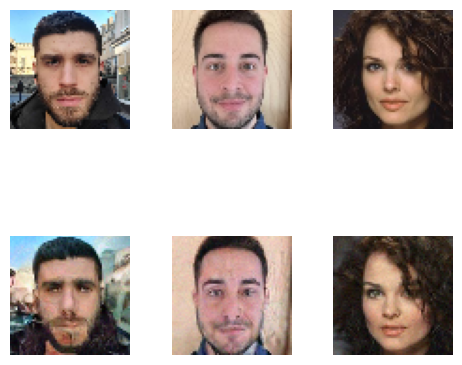

In [19]:
# show jan and georgios on one figure
fig, ax = plt.subplots(2,3, figsize=(5,5))
ax[0,0].imshow(jan.permute(1,2,0))
ax[0,1].imshow(georgios.permute(1,2,0))
ax[0,2].imshow(x[0].permute(1,2,0))
ax[1,0].imshow(reconstructed_jan[0].detach().cpu().permute(1,2,0))
ax[1,1].imshow(reconstructed_georgios[0].detach().cpu().permute(1,2,0))
ax[1,2].imshow(reconstructed_x[0].detach().cpu().permute(1,2,0))
# tight layout
plt.tight_layout()
# no axis
for a in ax.flatten():
    a.axis('off')   
plt.show()

# Ours FFHQ

In [3]:
import pickle
from utils import fix_rds_path

from lightning_modules.EncoderOnlyPretrainedScoreVAEmodel import EncoderOnlyPretrainedScoreVAEmodel
with open('/store/CIA/js2164/rds/gb511/projects/scoreVAE/experiments/paper/pretrained/FFHQ_128/only_encoder_ddpm_plus_smld_VAE_KLweight_0.01/config.pkl', 'rb') as f:
  config = pickle.load(f)

config.model.time_conditional = True
#diff_vae = EncoderOnlyPretrainedScoreVAEmodel.load_from_checkpoint('/store/CIA/js2164/rds/gb511/projects/scoreVAE/experiments/paper/pretrained/celebA_64/only_ResNetEncoder_VAE_KLweight_0.01/checkpoints/best/last.ckpt',
#                                                                    config=config)


from lightning_modules.utils import create_lightning_module
model = create_lightning_module(config)
pl_module = model.load_from_checkpoint(fix_rds_path(config.model.checkpoint_path), config=config)
pl_module.configure_sde(config)
pl_module = pl_module.to('cuda')
pl_module.eval()

Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../home/js2164/rds_work/projects/scoreVAE/experiments/paper/pretrained/FFHQ_128/prior/checkpoints/best/epoch=510--eval_loss_epoch=0.008.ckpt`


loaded


Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../home/js2164/rds_work/projects/scoreVAE/experiments/paper/pretrained/FFHQ_128/only_encoder_ddpm_plus_VAE_KLweight_0.01/checkpoints/best/last.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../home/js2164/rds_work/projects/scoreVAE/experiments/paper/pretrained/FFHQ_128/prior/checkpoints/best/epoch=510--eval_loss_epoch=0.008.ckpt`


loaded


EncoderOnlyPretrainedScoreVAEmodel(
  (unconditional_score_model): BeatGANsUNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)


In [4]:
import torchvision
path_jan = 'images_for_manipulation/jan3.jpg'
#jan=torchvision.io.read_image(path_jan)[:,:150,:]
jan=torchvision.io.read_image(path_jan)
min_dim = min(jan.shape[1], jan.shape[2])
offset = 0
jan = jan[:, offset:(min_dim+offset), :min_dim]
georgios = torchvision.io.read_image('images_for_manipulation/georgios.jpg')[:,25:225,50:250]
resize = torchvision.transforms.Resize((128,128))
jan=resize(jan)
# normalize to 0, 1
jan = jan/255
georgios=resize(georgios)
georgios = georgios/255

In [5]:
# reapeat jan 128 times
B=1
jan_batch = torch.stack([jan]*B).to('cuda')
latent_mean = False
reconstructed_jan = pl_module.encode_n_decode(jan_batch, use_pretrained=config.training.use_pretrained,
                                                          encoder_only=config.training.encoder_only,
                                                          t_dependent=config.training.t_dependent)
# georgios
georgios_batch = torch.stack([georgios]*B).to('cuda')
reconstructed_georgios = pl_module.encode_n_decode(georgios_batch, use_pretrained=config.training.use_pretrained,
                                                          encoder_only=config.training.encoder_only,
                                                          t_dependent=config.training.t_dependent)

  0%|          | 0/1000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.65 GiB total capacity; 1.20 GiB already allocated; 21.31 MiB free; 1.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# show jan and georgios on one figure
fig, ax = plt.subplots(2,3, figsize=(5,5))
ax[0,0].imshow(jan.permute(1,2,0))
ax[0,1].imshow(georgios.permute(1,2,0))
ax[0,2].imshow(x[0].permute(1,2,0))
ax[1,0].imshow(reconstructed_jan[0].detach().cpu().permute(1,2,0))
ax[1,1].imshow(reconstructed_georgios[0].detach().cpu().permute(1,2,0))
ax[1,2].imshow(reconstructed_x[0].detach().cpu().permute(1,2,0))
# tight layout
plt.tight_layout()
# no axis
for a in ax.flatten():
    a.axis('off')   
plt.show()